In [1]:
import os
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'transfer_learn'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance

from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params, task_name_dict, rule_set_names
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from tools_lnd import get_D, make_h_trial_rule, get_model_params, plot_N, same_stim_trial, remove_spines

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig_name = 'suppfig10'
figpath = os.path.join(p_code,'figs',fig_name,fig_name+'_ABCDEFG')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
# ##################################################################
# #data path
# ##################################################################
m = os.path.join(p_data,fig_name,fig_name+'_ABCDEFG')

In [4]:
task_dict = {}
task_dict['Dly Anti'] = rules_dict['all'][5]
task_dict['RT Go'] = rules_dict['all'][1]
task_dict['Dly Go'] = rules_dict['all'][2]
task_dict['RT Anti'] = rules_dict['all'][4]
task_dict['Anti'] = rules_dict['all'][3]
task_dict['Go'] = rules_dict['all'][0]
task_dict['DNMS'] = rules_dict['all'][12]
task_dict['DMS'] = rules_dict['all'][11]
task_dict['DMC'] = rules_dict['all'][13]
task_dict['DNMC'] = rules_dict['all'][14]
task_dict['Dly DM 2'] = rules_dict['all'][7]
task_dict['Dly DM 1'] = rules_dict['all'][6]
task_dict['Ctx Dly DM 2'] = rules_dict['all'][9]
task_dict['Ctx Dly DM 1'] = rules_dict['all'][8]
task_dict['MultSen Dly DM'] = rules_dict['all'][10]

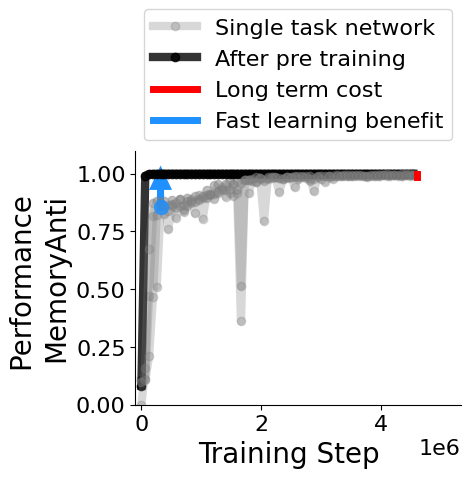

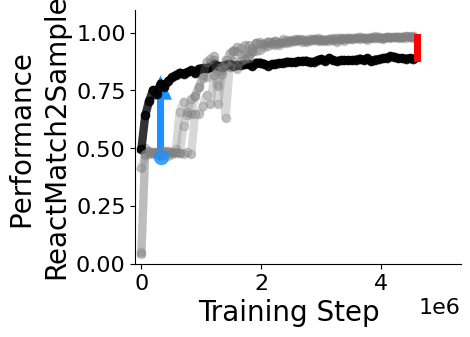

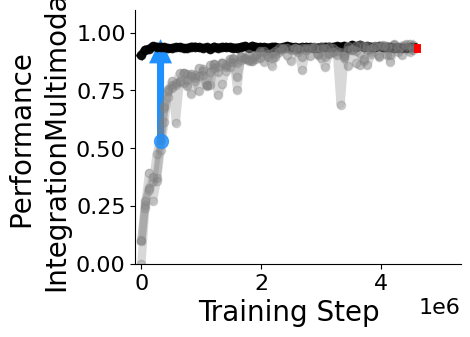

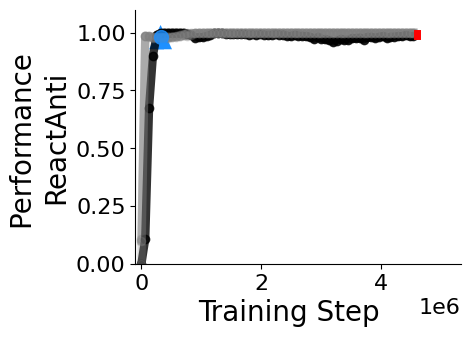

In [5]:
data_folder = 'final1'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'diag'
seed = '0'
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -6

comp_at2 = 5*64000#10048000#47360000#
comp_at1 = 4544000+64000#5952000

for pop_rule in [5,11,10,4]:# range(len(rule_trains_all)): #[5,11,8,9,10]: #
    
    fig = plt.figure(figsize=(4.2, 3.3))
    plt.rcParams.update({'font.size': 16})
    task_list = ['delayanti',]
    ax_cost = plt.subplot(111)

    rule_trains_pre = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
    'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
    'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

    rule_trains_pre.pop(pop_rule)

    post_train = rules_dict['all'][pop_rule]

    s = '_'
    rule_trains_str = s.join(rule_trains_pre)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    post_m = os.path.join(m,post_train,'pretrained_'+seed, 'log.json')
    
    with open(post_m, 'r') as f:
        log_post = json.load(f)
    
    for seed_str in ['4','5','6']:
        sing_m = os.path.join(m, post_train,'single_task_'+seed_str, 'log.json')

        with open(sing_m, 'r') as f:
            log_sing = json.load(f)

        plt.sca(ax_cost)
        x = log_sing['perf_'+post_train]
        
        if seed_str=='4':
            plt.plot(log_sing['trials'][:log_sing['trials'].index(comp_at1)],log_sing['perf_'+post_train][:log_sing['trials'].index(comp_at1)],'-o',c ='gray',
                 alpha = .3,linewidth = 6,label = 'Single task network')
            plt.plot(log_post['trials'][:log_sing['trials'].index(comp_at1)],log_post['perf_'+post_train][:log_sing['trials'].index(comp_at1)],'-o',c = 'k',
             alpha = .8,linewidth = 6,label = 'After pre training')
        else:
            plt.plot(log_sing['trials'][:log_sing['trials'].index(comp_at1)],log_sing['perf_'+post_train][:log_sing['trials'].index(comp_at1)],'-o',c ='gray',
                 alpha = .3,linewidth = 6)
    
    ax_cost.set_xlabel('Training Step  ',fontsize = 20)
    ax_cost.set_ylabel('Performance \n'+rule_set_names[pop_rule],fontsize = 20)

    comp_at = comp_at1
    y1 = (log_post['perf_'+post_train])[log_post['trials'].index(comp_at)]
    y2 = (log_sing['perf_'+post_train])[log_sing['trials'].index(comp_at)]
    x = comp_at
    
    plt.plot([comp_at,comp_at],[y1,y2],'-r',linewidth = 5,label = 'Long term cost')
        
    comp_at = comp_at2
    y1 = (log_post['perf_'+post_train])[log_post['trials'].index(comp_at)]
    y2 = (log_sing['perf_'+post_train])[log_sing['trials'].index(comp_at)]
    x = comp_at
    
    plt.plot([comp_at,comp_at],[y1,y1],'-',c = 'dodgerblue',linewidth = 5,label = 'Fast learning benefit')
    plt.arrow(comp_at,y2,0,-y2+y1,color = 'dodgerblue',alpha = 1,linewidth = 5, overhang = 0,
              length_includes_head =True, head_width=200000, head_length=0.055)
    plt.plot(comp_at,y2,'o',color = 'dodgerblue', alpha = .8,markersize = 10)
    
    if pop_rule==5:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.6))

    ax_cost.spines['top'].set_visible(False)
    ax_cost.spines['right'].set_visible(False)
    plt.sca(ax_cost)
    plt.ylim(0,1.1)
    plt.xlim(-100000,1.05*comp_at1+500000)

    figname = 'perf_transfer '+post_train
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')


In [6]:
def get_max_corr_epoch(m,epoch = 'go1'):
    cluster_var = np.load(os.path.join(m,'lesion_fps_hierarchical_ward_distance_opt_clust',
                                       'cluster_var.npz'))

    full_corr_mat = np.corrcoef(cluster_var['D'])
    feature_names_master = cluster_var['tick_names']
    len_te = len(feature_names_master)
    feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
    task_binary_True = {}
    task_binary_False = {}
    max_corr = {}
    max_corr_id = {}
    for rule in rules_dict['all']:
        
        task_binary_True[rule] = [((feat_name.rsplit(' ', 1)[0] == rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                  for feat_name in feature_names_master]
        task_binary_False[rule] = [((feat_name.rsplit(' ', 1)[0] != rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                   for feat_name in feature_names_master]

        max_corr[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        max_corr_id[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        
        for xi in range(len(np.argwhere(task_binary_True[rule]))):

            max_corr[rule][xi] = np.sort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            max_corr_id[rule][xi] = np.argsort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            
    return max_corr, max_corr_id

In [7]:
def get_max_corr_load_mat(mat,feature_names_master,epoch = 'go1'):

    full_corr_mat = mat
    len_te = len(feature_names_master)
    feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
    task_binary_True = {}
    task_binary_False = {}
    max_corr = {}
    max_corr_id = {}
    for rule in rules_dict['all']:
        
        task_binary_True[rule] = [((feat_name.rsplit(' ', 1)[0] == rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                  for feat_name in feature_names_master]
        task_binary_False[rule] = [((feat_name.rsplit(' ', 1)[0] != rule_name[rule]) & (feat_name.rsplit(' ', 1)[-1] == epoch))
                                   for feat_name in feature_names_master]

        max_corr[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        max_corr_id[rule] = np.zeros(len(np.argwhere(task_binary_True[rule])))
        
        for xi in range(len(np.argwhere(task_binary_True[rule]))):

            max_corr[rule][xi] = np.sort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            max_corr_id[rule][xi] = np.argsort(full_corr_mat[np.argwhere(task_binary_True[rule])[xi][0],
                                                   task_binary_False[rule]])[-1]
            
    return max_corr, max_corr_id

In [8]:
##########################################################3
############ DEMO of how corr_mat is calculated (see Fig 3B)

#for all_networks:
#    m = path_to_network
#    save_dir = os.path.join(m,lesion_folder)
#    cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
#    D = cluster_var['D'].T
#    feature_names_original = [cluster_var['tick_names'][s] for s in range(len(cluster_var['tick_names']))]
#    
#    feat_order = [feature_names_original.index(s) for i,s in enumerate(feature_names_master)]
#    X = D[:,feat_order]
#    
#    corr_mat = np.corrcoef(X.T)
#    
#    if len(corr_mat_stack)==0:
#        corr_mat_stack = corr_mat[:,np.newaxis]
#    else:
#        corr_mat_stack = np.concatenate((corr_mat_stack,corr_mat[:,np.newaxis]),axis=1)
#
#corr_mat_ave = np.mean(corr_mat_stack,axis = 1)

corr_mat_ave = np.load(os.path.join(m,'corr_mat_ave.npy'))

In [9]:
file = 'LeakyRNN_softplus_diag_15_tasks_128_n_rnn_lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo_1'
fig_name = 'fig3_5' 
feature_names_master_m = os.path.join(p_data,fig_name,file)

lesion_folder = 'lesion_fps_hierarchical_ward_distance_opt_clust'
save_dir = os.path.join(feature_names_master_m,lesion_folder)
cluster_var = np.load(os.path.join(save_dir,'cluster_var.npz'))
feature_names_master = cluster_var['tick_names'].astype(str)  # Convert to strings
feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]

In [10]:
feature_names_labels = [feat_name.rsplit(' ', 1)[0] for feat_name in feature_names_master]
task_labels = [task_name_dict[feat] for feat in feature_names_labels]
tasks = [task_dict[feat] for feat in feature_names_labels]

sharable_index = {}
unique_index = {}
for task in np.unique(tasks):
    ind = [tasks[x]==task for x in range(len(tasks))]
    ind_args = np.argwhere(ind)
    ind_not = [tasks[x] != task for x in range(len(tasks))]
    not_task_corr = corr_mat_ave[:,ind_not]
    
    max_period_cors = []
    for ind_i in ind_args:
        max_period_cors.append(np.sort(not_task_corr[ind_i,:],axis = 1)[0][-1])
        
    sharable_index[task] = np.max(max_period_cors)
    unique_index[task] = np.min(max_period_cors)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/__autograph_generated_filewmhsttb5.py:45: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(xi) is 0, if_body, else_body, get_state, set_state, ('gate_input_sum',), 1)


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 128) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.


2024-04-17 19:02:49.961857: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaygo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaydm1:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaydm2:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaygo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaydm1:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<t

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactgo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaygo:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_fdanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_reactanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delayanti:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel_input_delaydm1:0' shape=(1, 128) dtype=float32_ref>
0.158113883008419
Variables being optimized:
<t

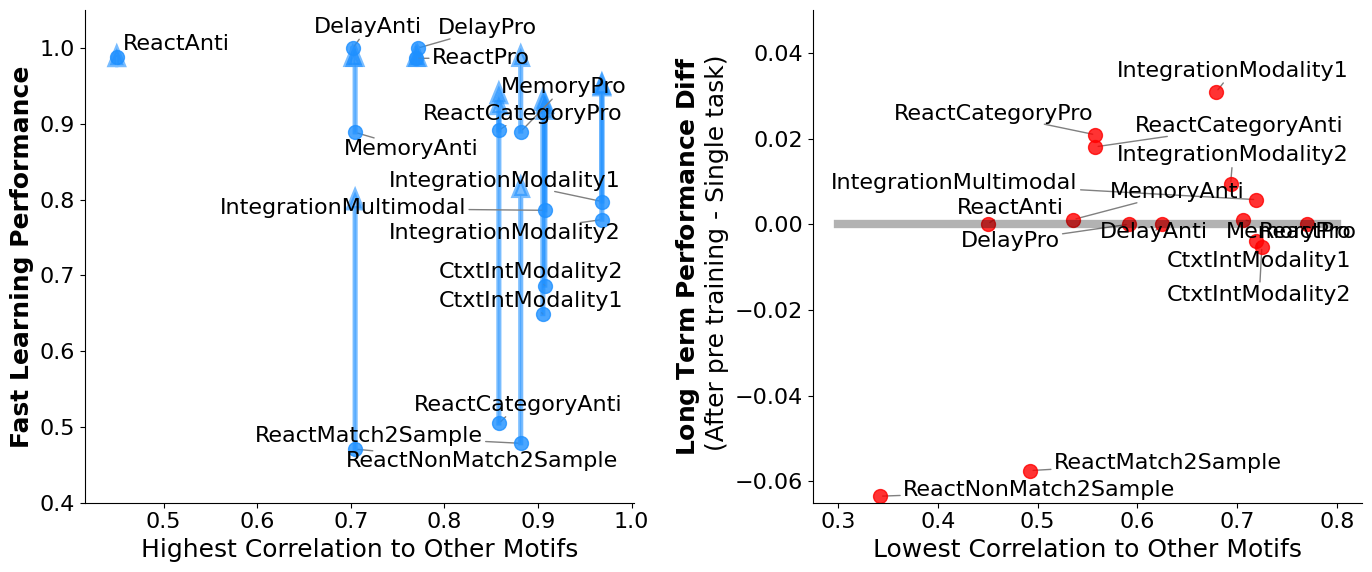

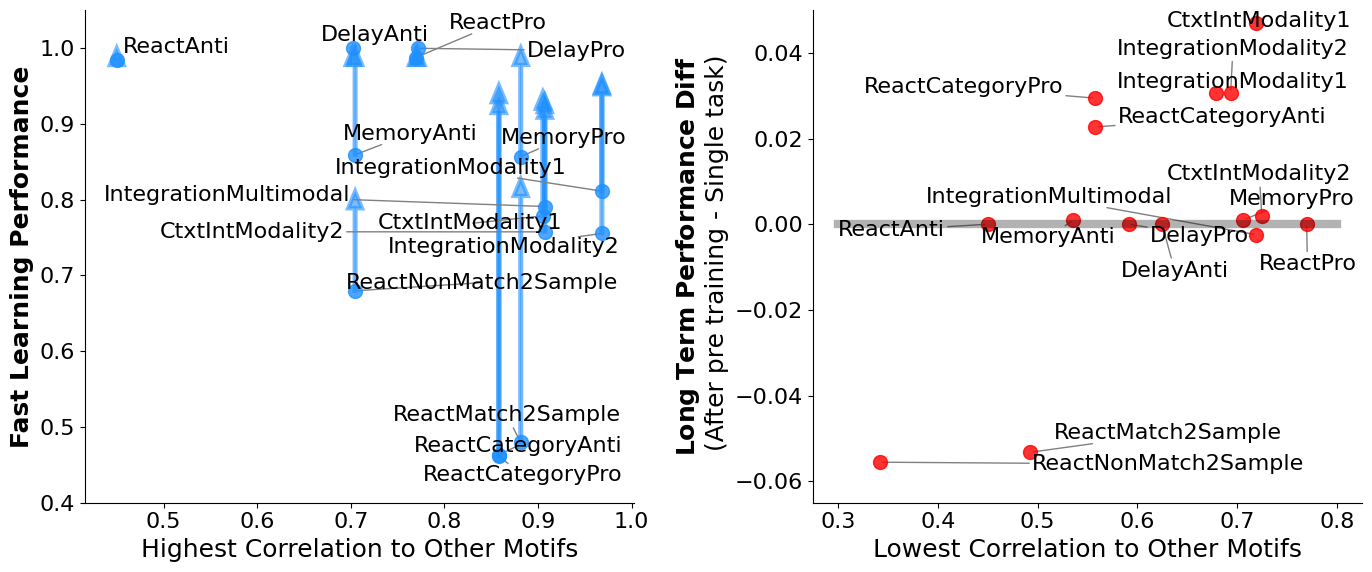

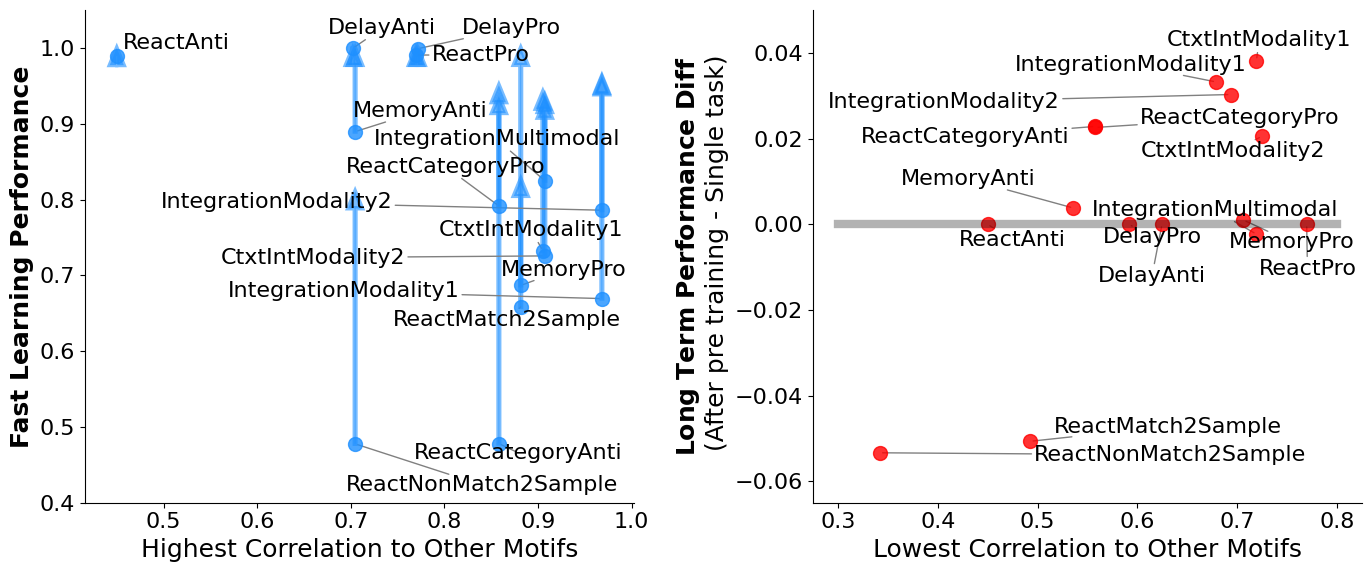

In [11]:
from adjustText import adjust_text
data_folder = 'final1'
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'diag'
seed = '0'
n_rnn = str(128)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -6
net_name_sing = 'lr6.0l2_w6.0_h6.0_sig_rec0.05_sig_x0.1_w_rec_coeff0.8_'

max_corr, max_corr_id = get_max_corr_load_mat(corr_mat_ave,feature_names_master,epoch = 'go1')

comp_at2 = 640000

for seed_int in range(4,7):
        
    fig = plt.figure(figsize=(14, 6))
    ax1 = plt.subplot(122)
    ax2 = plt.subplot(121)

    seed_str = str(seed_int)
    
    diff_perf = {}
    learn_ben_perf = {}
    together1 = []
    together2 = []

    for pop_rule in range(len(rules_dict['all'])):
        
        post_train = rules_dict['all'][pop_rule]
        sing_m = os.path.join(m, post_train,'single_task_'+seed_str)
        post_m = os.path.join(m, post_train,'pretrained_'+seed)

        model = Model(post_m)
        with open(post_m+ '/log.json', 'r') as f:
            log_post = json.load(f)
            perf_post = (log_post['perf_'+post_train])
        
        with open(sing_m+ '/log.json', 'r') as f:
            log_sing = json.load(f)
            perf_sing = (log_sing['perf_'+post_train])

        diff_perf[post_train] = np.max(perf_post)-np.max(perf_sing)
        learn_ben_perf[post_train] = [perf_post[log_post['trials'].index(comp_at2)],perf_sing[log_sing['trials'].index(comp_at2)]] 

        sharability = [sharable_index[post_train],sharable_index[post_train]] 
        uniqueness = [unique_index[post_train],unique_index[post_train]]                       

#             ax1.plot(sharability,diff_perf[post_train],'-r',label = post_train, alpha = .8,markersize = 10)
        plt.arrow(sharability[0],learn_ben_perf[post_train][1],0,-learn_ben_perf[post_train][1]+learn_ben_perf[post_train][0],
                  color = 'dodgerblue',alpha = .6,linewidth = 3, overhang = 0, head_width = .015, length_includes_head =True)

        ax1.plot(uniqueness[0],diff_perf[post_train],'or',label = post_train, alpha = .8,markersize = 10)
        ax2.plot(sharability[0],learn_ben_perf[post_train][1],'o',c = 'dodgerblue',label = post_train, alpha = .8,markersize = 10)

        together1.append((unique_index[post_train],diff_perf[post_train],rule_set_names[pop_rule],'k'))
        together2.append((sharable_index[post_train],learn_ben_perf[post_train][1],rule_set_names[pop_rule],'k'))

    plt.axes(ax2)
    plt.ylim([.4,1.05])
    texts = []
    for x, y, s, c in together2:
        texts.append(ax2.text(x, y, s, color = c, fontsize = 16))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='gray', lw=1))
    plt.ylabel('Fast Learning Performance',fontsize = 18, weight="bold")
    plt.xlabel('Highest Correlation to Other Motifs',fontsize = 18)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)

    plt.axes(ax1)
    plt.ylim([-.065,.05])
    plt.plot([.3,.8],[0,0],'-k',alpha = .3,linewidth = 6)
    texts = []
    for x, y, s, c in together1:
        texts.append(ax1.text(x, y, s, color = c, fontsize = 16))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="-", color='gray', lw=1))

    plt.ylabel(r"$\bf{Long \ Term \ Performance \ Diff}$"+' \n (After pre training - Single task)',fontsize = 18)
    plt.xlabel('Lowest Correlation to Other Motifs',fontsize = 18)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    fig.tight_layout()

    figname = 'perf_sharability_transfer_success_'+seed_str
    plt.savefig(os.path.join(figpath,figname+'.pdf'),bbox_inches = 'tight')
    # plt.savefig(os.path.join(figpath,figname+'.png'),bbox_inches = 'tight')


In [12]:
post_train = 'reactanti'
print(sharable_index[post_train],unique_index[post_train])

0.44994293938294505 0.44994293938294505
